### 모듈 입력
- 데이터 입력 및 전처리(numpy, pandas)
- 그래프 및 시각화(matplotlib)
- 학습데이터 구성 및 모델 생성(tensorflow, keras)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,Activation

### 데이터 전처리
- csv file load(pandas)
- 빈 데이터(Null) 확인 및 처리
- dataframe(pandas)-> numpy

In [2]:
# pandas csv file load
data = pd.read_csv('Train data(UDDS aging).csv')
# null 유/무 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
Ri               40 non-null float64
R_1s             40 non-null float64
R_60s            40 non-null float64
CV length        40 non-null int64
Cap_discharge    40 non-null float64
dtypes: float64(4), int64(1)
memory usage: 1.7 KB


In [3]:
# 데이터 확인(맨 위 5줄)
data.head()

,Ri,R_1s,R_60s,CV length,Cap_discharge
0,0.020581,0.002319,0.026490,10393,2.464430
1,0.020563,0.002564,0.027161,11097,2.460054
2,0.021119,0.002441,0.027161,11532,2.448338
3,0.021245,0.002625,0.027405,11989,2.439152
4,0.021612,0.002258,0.027283,12389,2.431225


In [4]:
# dataframe -> numpy로 변환
xy = data.iloc[:,:].values
xy.shape

(40, 5)

## 모델 생성
- Lstm(Long short term memory) 모델 생성
#### RNN 모델의 변형(vanishing gradient 극복), 다변량 예측 모델(입력값 다수)

In [5]:
# 데이터의 정규화(normalization) 함수 생성 - minmaxscaler 선택
def minmaxscaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / denominator           
    # noise term prevents the zero division:  (denominator + 1e-7)

In [6]:
x_data = xy[:, 0:-1]
y_data = xy[:, [-1]]
ymax, ymin = np.max(y_data), np.min(y_data)
xy = minmaxscaler(xy)

# seq_len : 예측에 반영되는 이전값의 time sequence 수
seq_len = 1
sequence_length = seq_len + 1

# seq_len 수에 따라 차원 변경(2차원 -> 3차원)
# 3차원 = (input data 길이, sequence_length, input 개수)
result=[]
for index in range(len(xy)-sequence_length):
    result.append(xy[index:index +sequence_length])
    result_data = np.array(result)
result_data.shape

(38, 2, 5)

In [7]:
# 학습 데이터, 테스트 데이터 분할
# 90% 데이터 : 학습 , 10% 데이터 : 테스트
# data_real : minmaxscaler함수 연산 이전의 기존 값
row=int(round(result_data.shape[0]*0.8))
train=result_data[:row,:]

X_data = result_data[:,:-1,:-1]
Y_data = result_data[:,-1,-1]
Y_data_real = Y_data*(ymax-ymin)+ymin
print('X_data : ', X_data.shape)
print('Y_data : ', Y_data.shape)

X_train=train[:,:-1,:-1]
Y_train=train[:,-1,-1]
print('X_train : ', X_train.shape)
print('Y_train : ', Y_train.shape)

X_test=result_data[row:,:-1,:-1]
Y_test=result_data[row:,-1,-1]
Y_test_real = Y_test*(ymax-ymin)+ymin
print('X_test : ', X_test.shape)
print('Y_test : ', Y_test.shape)

X_data :  (38, 1, 4)
Y_data :  (38,)
X_train :  (30, 1, 4)
Y_train :  (30,)
X_test :  (8, 1, 4)
Y_test :  (8,)


In [8]:
# 모델 생성(Keras 기반)
# 파라미터(layer, cell,...)선정, Dropout(0.2) 적용으로 과적합 방지
model=Sequential()
model.add(LSTM(128,return_sequences=False,input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(Dense(1,activation='linear'))
model.compile(loss='mse',optimizer='adam',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               68096     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 학습과 동시에 Loss값 저장(mini batch 적용x, epochs : 20 )
hist=model.fit(X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=1,
    epochs=30)

Train on 30 samples, validate on 8 samples
Epoch 1/30
30/30 [==============================] - 6s 194ms/sample - loss: 0.2412 - acc: 0.0000e+00 - val_loss: 0.1399 - val_acc: 0.0000e+00
Epoch 2/30
30/30 [==============================] - 0s 8ms/sample - loss: 0.1467 - acc: 0.0000e+00 - val_loss: 0.3073 - val_acc: 0.0000e+00
Epoch 3/30
30/30 [==============================] - 0s 9ms/sample - loss: 0.1230 - acc: 0.0000e+00 - val_loss: 0.3073 - val_acc: 0.0000e+00
Epoch 4/30
30/30 [==============================] - 0s 8ms/sample - loss: 0.1016 - acc: 0.0000e+00 - val_loss: 0.2058 - val_acc: 0.0000e+00
Epoch 5/30
30/30 [==============================] - 0s 9ms/sample - loss: 0.0858 - acc: 0.0000e+00 - val_loss: 0.1715 - val_acc: 0.0000e+00
Epoch 6/30
30/30 [==============================] - 0s 9ms/sample - loss: 0.0703 - acc: 0.0000e+00 - val_loss: 0.1501 - val_acc: 0.0000e+00
Epoch 7/30
30/30 [==============================] - 0s 8ms/sample - loss: 0.0504 - acc: 0.0000e+00 - val_loss: 0.06

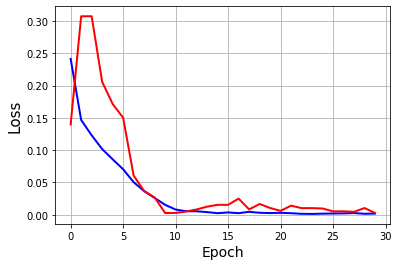

In [10]:
# 학습 결과(Epoch에 따른 Loss 감소) 시각화
plt.plot(hist.history['loss'],'b-', linewidth=2.0,label='train_loss')
plt.plot(hist.history['val_loss'], 'r-', linewidth=2.0,label='test_loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=15)
plt.grid()

In [11]:
# loss 확인
loss_and_metrics = model.evaluate(X_test, Y_test, batch_size=20)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

8/1 [================================================================================================================================================================================================================================================] - 1s 121ms/sample - loss: 0.0028 - acc: 0.0000e+00
## evaluation loss and_metrics ##
[0.0027520901057869196, 0.0]


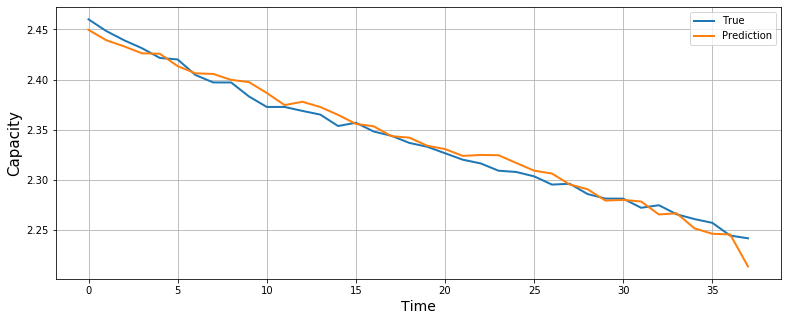

In [12]:
# 예측 값 시각화(data 전체 값)
pred=model.predict(X_data)
pred = pred*(ymax-ymin)+ymin
fig=plt.figure(figsize=(13,5))
plt.plot(Y_data_real,linewidth=2.0,label='True')
plt.plot(pred,linewidth=2.0,label='Prediction')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Capacity', fontsize=15)
plt.legend()
plt.grid()
plt.show()

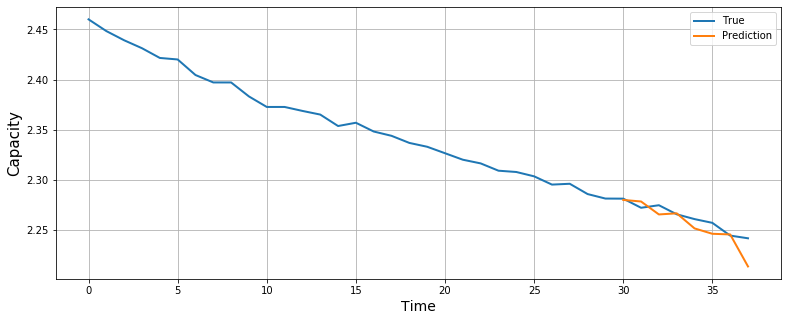

In [13]:
# 예측 값 시각화(test 값)
pred=model.predict(X_test)
pred = pred*(ymax-ymin)+ymin
fig=plt.figure(figsize=(13,5))
plt.plot(Y_data_real, linewidth=2.0, label='True')
plt.plot(np.arange(row, row + len(pred), 1), pred, linewidth=2.0, label='Prediction')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Capacity', fontsize=15)
plt.legend()
plt.grid()
plt.show()

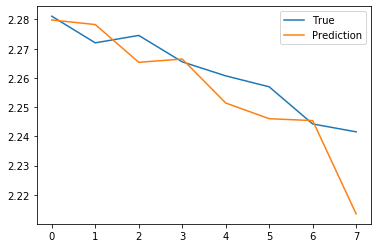

In [14]:
# 예측 값 시각화(test 값)
pred=model.predict(X_test)
pred = pred*(ymax-ymin)+ymin
Y_test = Y_test*(ymax-ymin)+ymin
fig=plt.figure(facecolor='white')
plt.plot(Y_test,label='True')
plt.plot(pred,label='Prediction')
plt.legend()
plt.show()

In [15]:
# 에러율 계산
np.mean(abs((Y_test - pred.T)/Y_test)*100)

0.37225025006610246